# Compare neighbourhoods

In [4]:
library(SingleCellExperiment)
library(miloR)
library(DelayedArray)
library(Matrix)
library(ggraph)
library(igraph)
library(viridis)
source("../data-in/rabbit/load_rabbit.R")
source("../scrabbitr/R/plot_utils.R") #temp

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

## Load data

In [2]:
# Load data
r_data <- loadRabbitData()
r_data

class: SingleCellExperiment 
dim: 30725 146133 
metadata(0):
assays(2): counts logcounts
rownames(30725): ENSOCUG00000014251 ENSOCUG00000005054 ...
  ENSG00000175602 ENSG00000172324
rowData names(1): V1
colnames(146133): cell_1 cell_2 ... cell_172994 cell_172995
colData names(14): cell barcode ... sizeFactor celltype
reducedDimNames(3): UMAP TSNE PCA
altExpNames(0):

In [3]:
reducedDim(r_data,"PCA") <- as.matrix(reducedDim(r_data,"PCA"))

In [25]:
m_data <- readRDS("../data-in/mouse/integrated_sce.rds")
m_data


class: SingleCellExperiment 
dim: 23972 430339 
metadata(0):
assays(2): counts logcounts
rownames(23972): ENSMUSG00000001138 ENSMUSG00000001143 ...
  ENSMUSG00000108929 ENSMUSG00000109022
rowData names(0):
colnames(430339): cell_1 cell_2 ... ext_cell_351871 ext_cell_351872
colData names(0):
reducedDimNames(0):
altExpNames(0):

In [26]:
m_pcs <- readRDS("../data-in/mouse/integrated_corrected_pcs.rds")
reducedDim(m_data,"PCA") <- as.matrix(m_pcs)

In [27]:
m_meta <- read.table("../data-in/mouse/meta.tsv",sep="\t")
m_data$celltype <- m_meta$celltype.clustering

In [28]:
m_meta2 <- readRDS("../data-in/mouse/integrated_metadata.rds")
reducedDim(m_data,"UMAP") <- m_meta2[,c("BBKNN_UMAP1","BBKNN_UMAP2")]

In [28]:
orthologs <- read.table("../data-in/orthologs.tsv",sep="\t")
orthologs[1:5,]

,ref,query
,<chr>,<chr>
ENSOCUG00000000006,ENSOCUG00000000006,ENSMUSG00000026102
ENSOCUG00000000007,ENSOCUG00000000007,ENSMUSG00000028480
ENSOCUG00000000008,ENSOCUG00000000008,ENSMUSG00000070999
ENSOCUG00000000009,ENSOCUG00000000009,ENSMUSG00000028478
ENSOCUG00000000010,ENSOCUG00000000010,ENSMUSG00000028479


## Compute neighbourhoods

In [4]:
# Compute rabbit neighbourhoods
r_milo <- Milo(r_data)
r_milo <- buildGraph(r_milo, k=30, d=50, reduced.dim="PCA")
r_milo <- makeNhoods(r_milo, prop=0.05, k=30, d=50,refined=T, reduced_dims="PCA")


Constructing kNN graph with k:30

Checking valid object



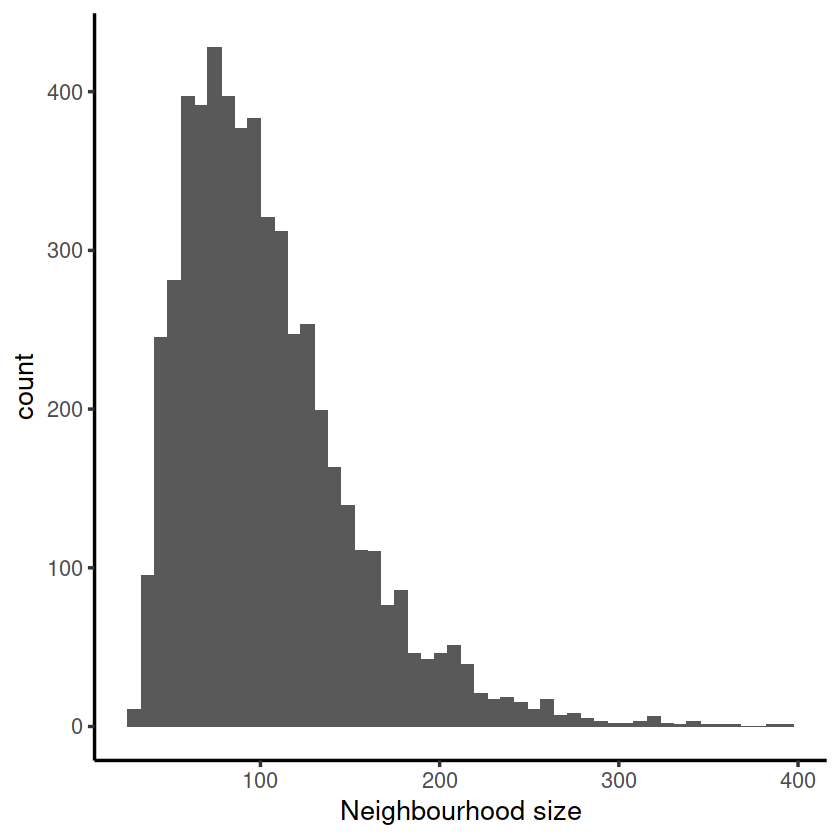

In [38]:
plotNhoodSizeHist(r_milo)

Warning message in plotNhoodGraph(r_milo):
“Coercing layout to matrix format”


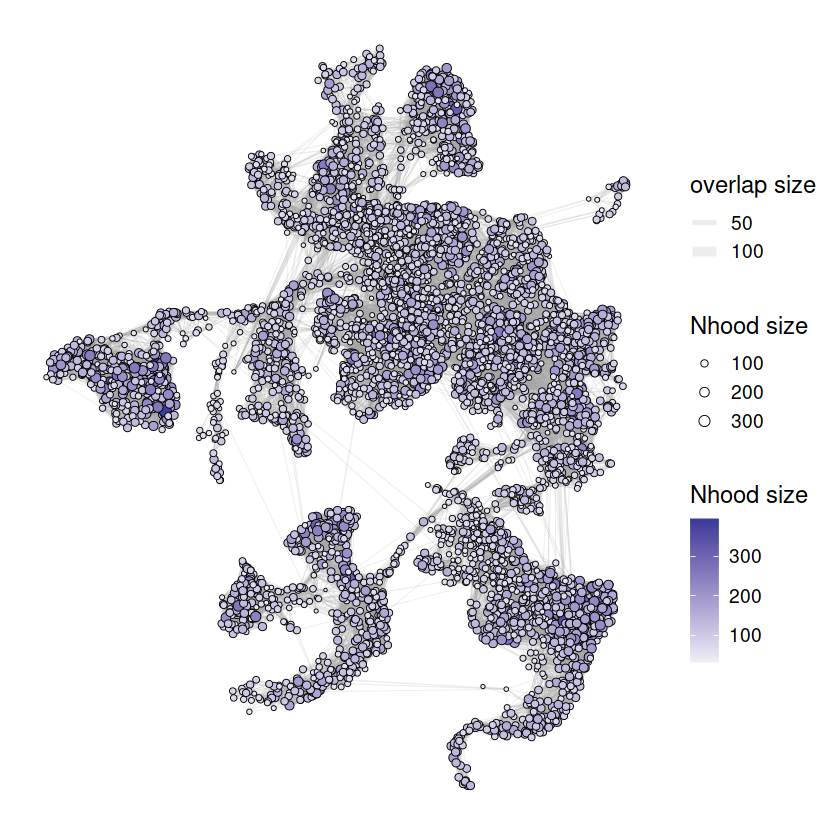

In [5]:
r_milo <- buildNhoodGraph(r_milo)
plotNhoodGraph(r_milo)

In [1]:
r_milo <- readRDS("../data-out/compare_neighbourhoods/r_milo.rds")
#writeMM(r_milo@nhoods,"../data-out/compare_neighbourhoods/r_nhoods.mtx")
#saveRDS(r_milo,"../data-out/compare_neighbourhoods/r_milo.rds")

In [29]:
# Compute mouse neighbourhoods
m_milo <- Milo(m_data)
m_milo <- buildGraph(m_milo, k=30, d=50, reduced.dim="PCA")
m_milo <- makeNhoods(m_milo, prop=0.05, k=30, d=50,refined=T, reduced_dims="PCA")

Constructing kNN graph with k:30

Checking valid object



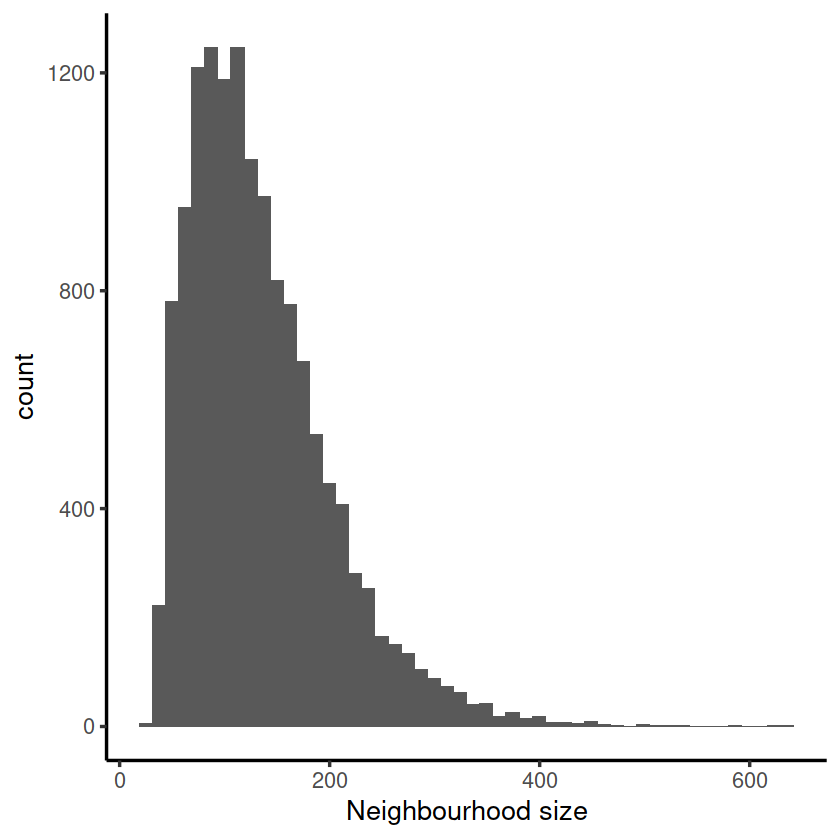

In [30]:
plotNhoodSizeHist(m_milo)

Warning message in plotNhoodGraph(m_milo):
“Coercing layout to matrix format”


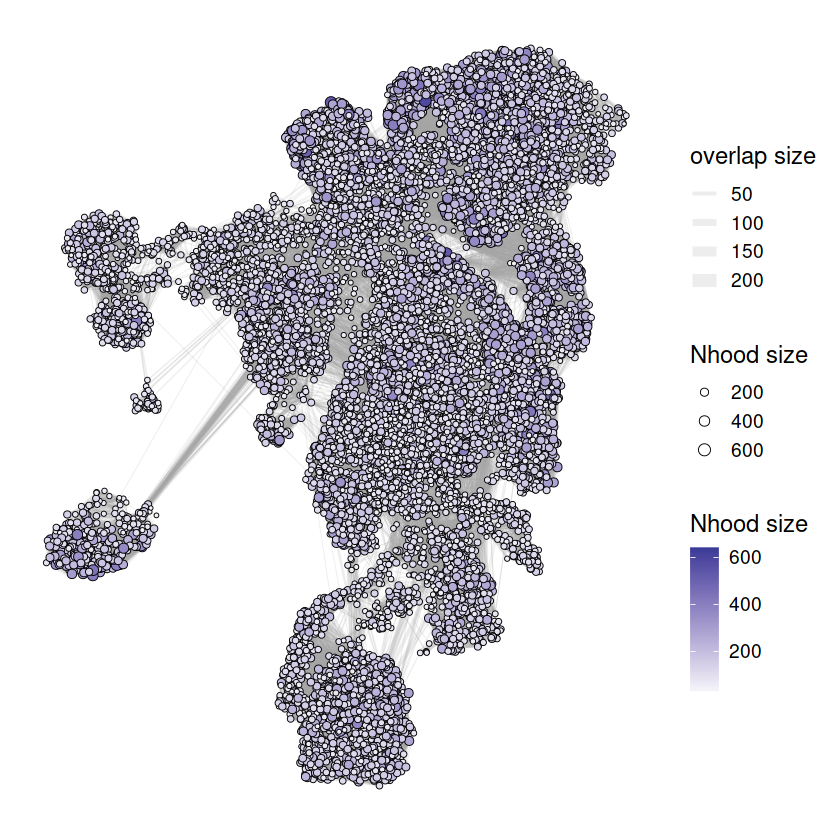

In [33]:
m_milo <- buildNhoodGraph(m_milo)
plotNhoodGraph(m_milo)

In [2]:
m_milo <- readRDS("../data-out/compare_neighbourhoods/m_milo.rds")
#m_nhoods <- readRDS("../data-out/compare_neighbourhoods/m_nhoods.rds")
#saveRDS(m_milo,"../data-out/compare_neighbourhoods/m_milo.rds")
#saveRDS(m_milo@nhoods,"../data-out/compare_neighbourhoods/m_nhoods.rds")
#writeMM(m_milo@nhoods,"../data-out/compare_neighbourhoods/m_nhoods.mtx")

## Plot similarity

In [5]:
# Load correlation
nhood_sim = fread("../data-out/compare_neighbourhoods/gspec_cor.tsv", sep="\t",data.table=F)
colnames(nhood_sim) <- vertex_attr(nhoodGraph(m_milo))$name
rownames(nhood_sim) <- vertex_attr(nhoodGraph(r_milo))$name

In [ ]:
nhood_sim[1:5,1:5]

In [20]:
dim(nhood_sim)

[1]  5253 14034

In [6]:
# For each nhood get nhood with maximum similarity in other species
r_maxsim <- apply(nhood_sim,1,FUN=which.max)
m_maxsim <- apply(nhood_sim,2,FUN=which.max)

In [7]:
# Reshape nhood similarities 
df_sim = reshape2::melt(as.matrix(nhood_sim))
colnames(df_sim) <- c("r_nhood", "m_nhood", "sim")
df_sim[1:5,]

,r_nhood,m_nhood,sim
,<int>,<int>,<dbl>
1,57511,247238,0.7701123
2,104077,247238,0.7368739
3,30659,247238,0.6408942
4,19736,247238,0.4544493
5,73244,247238,0.6944852


In [8]:
# For each nhood extract only its closest nhood in the other species
df_sim <- df_sim[order(df_sim$r_nhood, -df_sim$sim), ] 
r_maxNhoods <- df_sim[!duplicated(df_sim$r_nhood),]

df_sim <- df_sim[order(df_sim$m_nhood, -df_sim$sim), ] 
m_maxNhoods <- df_sim[!duplicated(df_sim$m_nhood),]

df_simFilt <- rbind(r_maxNhoods,m_maxNhoods)
dim(df_simFilt)

[1] 19287     3

In [9]:
# Subset neighbourhoods based on colData observation
subsetNhoods <- function(milo, obs, values) {
    milo_graph <- nhoodGraph(milo)
    nhood_ids <- as.numeric(vertex_attr(milo_graph)$name)
    nhood_obs <- colData(milo)[nhood_ids,obs]
    nhood_filt <- as.character(nhood_ids[nhood_obs %in% values])
    return(nhood_filt)
}

In [13]:
r_graph <- nhoodGraph(r_milo)
m_graph <- nhoodGraph(m_milo)

r_nhoodFilt <- subsetNhoods(r_milo, "celltype", c("Allantois","Lateral plate mesoderm", "Epiblast", "Primitive Streak", "Nascent mesoderm"))
m_nhoodFilt <- subsetNhoods(m_milo, "celltype", c("Allantois","Lateral plate mesoderm", "Epiblast", "Primitive Streak", "Nascent mesoderm"))

r_graphFilt <- induced_subgraph(r_graph, r_nhoodFilt)
m_graphFilt <- induced_subgraph(m_graph, m_nhoodFilt)

In [41]:
plotNhoodSim <- function(r_milo, m_milo, df_sim, reduced_dim="UMAP", colour_by, r_graph=NULL, m_graph=NULL, offset=c(10,0),
                        reflect.X=FALSE, reflect.Y = FALSE, rotate=NULL, line_alpha=0.05, edge_alpha=0.2,
                        colours=celltype_colours) {
    

    # Check if subset graph provided
    if(is.null(r_graph)) {
        r_graph <- nhoodGraph(r_milo)
    }
    
    if(is.null(m_graph)) {
        m_graph <- nhoodGraph(m_milo)
    }
    
    # Extract nhood embedding positions from mouse graph
    r_nhoodIDs <- as.numeric(vertex_attr(r_graph)$name)
    V(r_graph)$colour_by <- colData(r_milo)[r_nhoodIDs, colour_by]
    r_nhoodPos <- reducedDim(r_milo, reduced_dim)[r_nhoodIDs,]
    rownames(r_nhoodPos) <- as.character(r_nhoodIDs)
    colnames(r_nhoodPos) <- c("x","y")

    
    # Extract nhood embedding positions from mouse graph
    m_nhoodIDs <- as.numeric(vertex_attr(m_graph)$name)
    V(m_graph)$colour_by <- colData(m_milo)[m_nhoodIDs, colour_by]
    m_nhoodPos <- reducedDim(m_milo, reduced_dim)[m_nhoodIDs,]
    rownames(m_nhoodPos) <- as.character(m_nhoodIDs)
    colnames(m_nhoodPos) <- c("x","y")
    
    # TODO: Fix this
    if(!is.null(rotate)) {
        rotate <- rotate*pi/180
        com <- colMeans(m_nhoodPos[,1:2])
        m_nhoodPos = sweep(m_nhoodPos,2,com, "-")
        m_nhoodPos[,1] = m_nhoodPos[,1]*cos(rotate) - m_nhoodPos[,2]*sin(rotate)
        m_nhoodPos[,2] = m_nhoodPos[,1]*sin(rotate) + m_nhoodPos[,2]*cos(rotate)
        m_nhoodPos = sweep(m_nhoodPos,2,com, "+")
    }
    if(reflect.X) { m_nhoodPos[,1] = -m_nhoodPos[,1]}
    if(reflect.Y) {  m_nhoodPos[,2] = -m_nhoodPos[,2]}
    
    
    # Add spacing to offset mouse and rabbit umaps
    m_nhoodPos[,1] <- m_nhoodPos[,1] + offset[1]
    m_nhoodPos[,2] <- m_nhoodPos[,2] + offset[2]
    
    
    r_df <- cbind(r_nhoodPos, V(r_graph)$colour_by)
    colnames(r_df) <- c("x","y","obs")

    m_df <- cbind(m_nhoodPos, V(m_graph)$colour_by)
    colnames(m_df) <- c("x","y","obs")
    
    # Plot nhoods and nhood graphs
    df_plot <- rbind(r_df, m_df)
    p <- ggplot(df_plot,aes(x=x,y=y)) + 
        geom_edge_link0(data=get_edges(format="short")(create_layout(simplify(r_graph),layout=r_nhoodPos)), 
                        edge_colour = "grey66", edge_alpha=0.2) +
        geom_edge_link0(data=get_edges(format="short")(create_layout(simplify(m_graph),layout=m_nhoodPos)), 
                        edge_colour = "grey66", edge_alpha=0.2) +
        geom_point(aes(fill=obs),stroke=0.1,shape=21) +
        scale_fill_manual(values = celltype_colours, name = "") + theme(legend.position="none")


    # Filter sim data frame to nhoods within graphs provided
    sim_filt <- df_sim[(df_sim$r_nhood %in%  r_nhoodIDs) & 
                       (df_sim$m_nhood %in% m_nhoodIDs),]
    
    # Give each line a unique name
    sim_filt$alignment <- paste0("align_",sim_filt$r_nhood,"_",sim_filt$m_nhood)
    
    # Link rabbit and mouse nhood positions by alignment name
    r_lines <- sim_filt
    r_lines[,c("x","y")] <- r_nhoodPos[as.character(r_lines$r_nhood),]

    m_lines <- sim_filt
    m_lines[, c("x","y")] <- m_nhoodPos[as.character(m_lines$m_nhood),]
    df_lines <- rbind(r_lines, m_lines)

    # Add similarities lines
    p <- p + geom_line(data=df_lines,aes(x=x,y=y, group=alignment,colour=sim),alpha=line_alpha) +
    scale_colour_viridis(limits=c(min(df_lines$sim), max(df_lines$sim)))
    

    # Add theme
    p <- p +  theme_classic(base_size=14) +
    theme(axis.line = element_blank(), axis.text = element_blank(),
      axis.ticks = element_blank(), axis.title = element_blank(),
       legend.position="none",aspect.ratio=1) 


    return(p)
        
}
    


In [16]:
extractEdges <- function(layout) {
    edges <- collect_edges(layout)
    edges <-  format_short_edges(edges, layout)
    edges <- do.call(
      cbind,
      c(
        list(edges),
        lapply(list(...), rep, length.out = nrow(edges)),
        list(stringsAsFactors = FALSE)
      )
    )
    attr(edges, 'type_ggraph') <- 'edge_ggraph'
    edges
  }

r_layout <- reducedDim(r_milo, "UMAP")[as.numeric(vertex_attr(r_graph)$name),]
colnames(r_layout) <- c("x","y")
test<-create_layout(simplify(r_graph),layout=r_layout)


In [ ]:
get_edges(format="short")(test)

In [29]:
r_graph <- nhoodGraph(r_milo)
m_graph <- nhoodGraph(m_milo)

r_nhoodFilt <- subsetNhoods(r_milo, "celltype", c("Visceral endoderm","Hypoblast", "Midgut", "Gut tube","Primitive Streak", "Epiblast","PGC", "Otic placode", "Notochord", "Pharyngeal endoderm"))
m_nhoodFilt <- subsetNhoods(m_milo, "celltype", c("Visceral endoderm","ExE endoderm", "Midgut", "Gut tube","Primitive Streak", "Epiblast","Foregut", "Hindgut","Pharyngeal endoderm"))

r_graphFilt <- induced_subgraph(r_graph, r_nhoodFilt)
m_graphFilt <- induced_subgraph(m_graph, m_nhoodFilt)

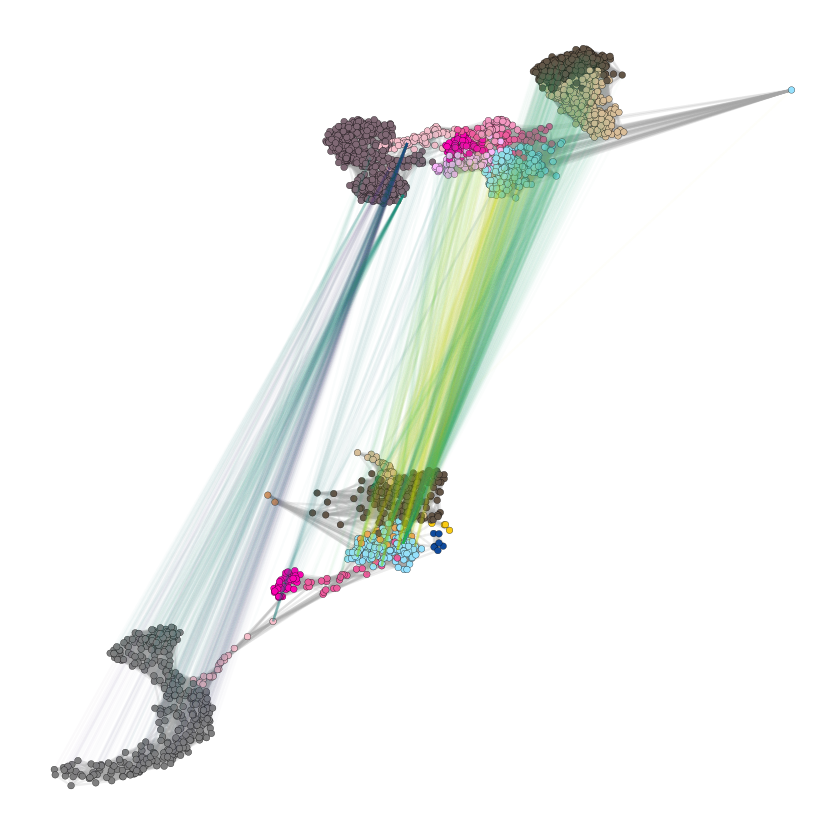

In [42]:
plotNhoodSim(r_milo, m_milo, df_simFilt, "UMAP", "celltype", r_graphFilt, m_graphFilt, offset=c(20,20),reflect.Y=FALSE,line_alpha=0.02)

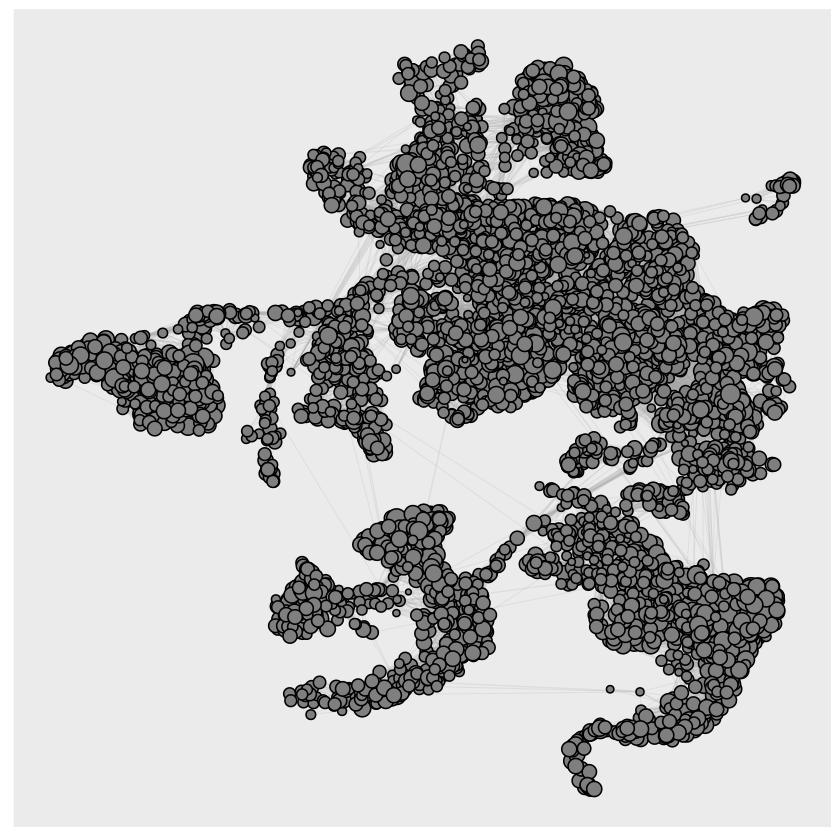

In [345]:
r_layout <- reducedDim(r_milo, "UMAP")[as.numeric(vertex_attr(r_graph)$name),]
colnames(r_layout) <- c("x","y")
p <- ggraph(simplify(r_graph), layout = r_layout) +
      geom_edge_link0(aes(width = weight), edge_colour = "grey66", edge_alpha=0.2) +
      geom_node_point(aes(fill = "celltype", size = size), shape=21) +
      scale_fill_manual(values = celltype_colours, name="") + 
      scale_edge_width(range = c(0.2,3), name="overlap size") + theme(legend.position="none")
p

In [ ]:
str(p)

In [304]:
m_milo

class: Milo 
dim: 23972 430339 
metadata(0):
assays(2): counts logcounts
rownames(23972): ENSMUSG00000001138 ENSMUSG00000001143 ...
  ENSMUSG00000108929 ENSMUSG00000109022
rowData names(0):
colnames(430339): cell_1 cell_2 ... ext_cell_351871 ext_cell_351872
colData names(1): celltype
reducedDimNames(2): PCA UMAP
altExpNames(0):
nhoods dimensions(2): 430339 14034
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(1): graph
nhoodIndex names(1): 14034
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 14034 14034

In [236]:
test <- vertex_attr(m_graphFilt)$name
test[!(test %in% df_simFilt$m_nhood)]

character(0)

In [257]:
plotNhoodSim(r_milo, m_milo, df_simFilt, "celltype", offset=c(30,30), reflect.X=FALSE, reflect.Y=FALSE,rotate=0,line_alpha=0.05)

In [256]:
ggsave("../data-test/compare_neighbourhoods/milo_gut_test.pdf", p)

Saving 6.67 x 6.67 in image



In [283]:
unique(m_milo$celltype)

[1] "Epiblast"                             
 [2] "Primitive Streak"                     
 [3] "ExE ectoderm"                         
 [4] "Visceral endoderm"                    
 [5] "ExE endoderm"                         
 [6] "Non-neural ectoderm 5"                
 [7] "Nascent mesoderm"                     
 [8] "Ectoderm"                             
 [9] "Blood progenitors"                    
[10] "Paraxial mesoderm"                    
[11] "Caudal epiblast"                      
[12] "Lateral plate mesoderm"               
[13] "Intermediate mesoderm"                
[14] "Cardiopharyngeal progenitors SHF"     
[15] "PGC"                                  
[16] "Mesenchyme"                           
[17] "Haematoendothelial progenitors"       
[18] "Gut tube"                             
[19] "Cardiomyocytes FHF 1"                 
[20] "Allantois endothelium"                
[21] "Node"                                 
[22] "Erythroid"                            
[23] "Embryo proper endothelium"            
[24] "Anterior somitic tissues"             
[25] "Cranial mesoderm"                     
[26] "Non-neural ectoderm 3"                
[27] "Parietal endoderm"                    
[28] "Anterior Primitive Streak"            
[29] "Presomitic mesoderm"                  
[30] "Allantois"                            
[31] "Non-neural ectoderm 4"                
[32] "EMP"                                  
[33] "Anterior cardiopharyngeal progenitors"
[34] "Pharyngeal mesoderm"                  
[35] "Limb mesoderm"                        
[36] "Midgut"                               
[37] "Venous endothelium"                   
[38] "Pharyngeal endoderm"                  
[39] "Hindgut"                              
[40] "Notochord"                            
[41] "Epicardium"                           
[42] "Posterior somitic tissues"            
[43] "Optic vesicle"                        
[44] "Somitic mesoderm"                     
[45] "Hindbrain floor plate"                
[46] "Caudal mesoderm"                      
[47] "Thyroid primordium"                   
[48] "Dermomyotome"                         
[49] "Cardiomyocytes SHF 1"                 
[50] "Placodal ectoderm"                    
[51] "NMPs"                                 
[52] "Dorsal spinal cord progenitors"       
[53] "Spinal cord progenitors"              
[54] "Midbrain progenitors"                 
[55] "Ventral forebrain progenitors"        
[56] "Hindbrain neural progenitors"         
[57] "Cardiomyocytes FHF 2"                 
[58] "Cardiopharyngeal progenitors FHF"     
[59] "Late dorsal forebrain progenitors"    
[60] "Migratory neural crest"               
[61] "Ventral hindbrain progenitors"        
[62] "Midbrain/Hindbrain boundary"          
[63] "Foregut"                              
[64] "Non-neural ectoderm 1"                
[65] "Mesothelium"                          
[66] "EPDC"                                 
[67] "Sclerotome"                           
[68] "Otic placode"                         
[69] "Dorsal hindbrain progenitors"         
[70] "Cardiomyocytes SHF 2"                 
[71] "YS endothelium"                       
[72] "NMPs/Mesoderm-biased"                 
[73] "Neural tube"                          
[74] "Endocardium"                          
[75] "MEP"                                  
[76] "Dorsal midbrain neurons"              
[77] "Non-neural ectoderm 2"                
[78] "Megakariocytes"                       
[79] "Branchial arch neural crest"          
[80] "Cardiopharyngeal progenitors"         
[81] "Erythroid/Masked"                     
[82] "Otic neural progenitors"              
[83] "Frontonasal mesenchyme"               
[84] "Early dorsal forebrain progenitors"   
[85] "Mesothelium-endothelium/Masked"       
[86] "Forelimb"                             
[87] "Nephron progenitors"

In [222]:
r_celltypes <- read.table("../data-in/rabbit/annotation_12-07-21.tsv",sep="\t",row.names=1,header=T)

In [224]:
r_milo$celltype <- r_celltypes$updated_celltype

In [227]:
r_milo$celltype[r_milo$celltype == "ExE endoderm"]

character(0)

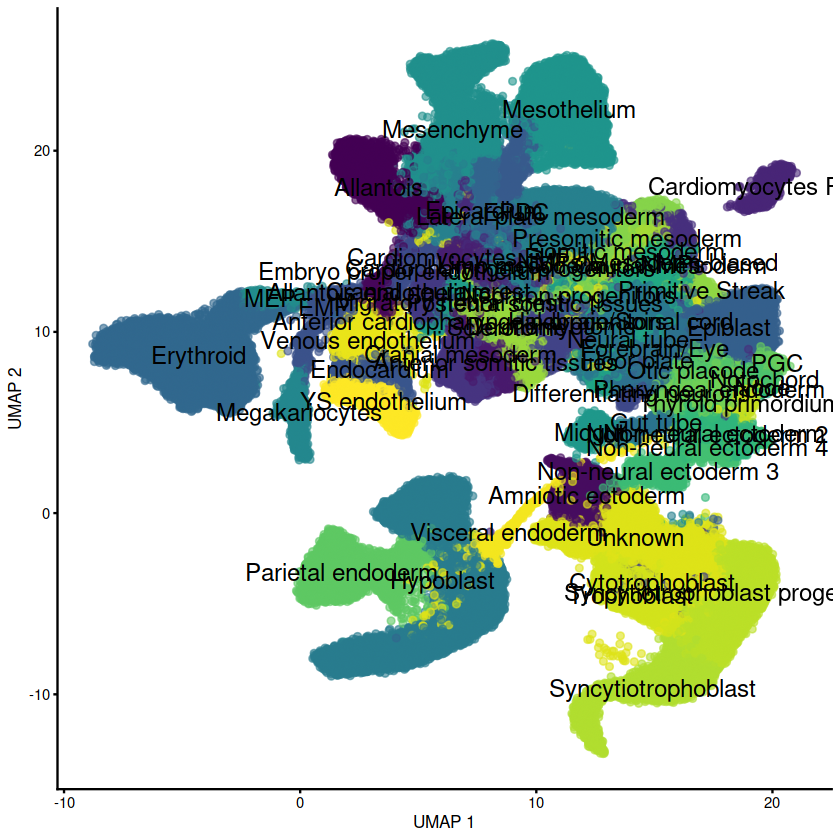

In [230]:
plotReducedDim(r_data, "UMAP", colour_by="celltype", text_by="celltype") + theme(legend.position="none")